<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**It's not always about convincing your parents of what you want to do, but just saying, 'This is what I'm doing; this is what I love' - [Stormzy](https://en.wikipedia.org/wiki/Stormzy)**

# Optimisation

###### Set-up

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

Defining functions we will be using for our reports later

In [2]:
from sklearn.metrics import roc_auc_score
def scores(model, X_train, X_val, y_train, y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [3]:
def annot(fpr,tpr,thr):
    k=0
    for i, j in zip(fpr,tpr):
        if k % 50 == 0:
            plt.annotate(round(thr[k],2),
                         xy=(i,j), 
                         textcoords='data')
        k+=1

In [4]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [5]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

## Data preparation

In [6]:
food = pd.read_csv('Resources/foodinfo.csv')
food.shape

(228844, 10)

In [7]:
food.head()

,product_name,additives_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,nutrition-score-uk_100g
0,Banana Chips Sweetened (Whole),0.0,2243.0,28.57,28.57,64.29,14.29,3.57,0.00000,14.0
1,Peanuts,0.0,1941.0,17.86,0.00,60.71,17.86,17.86,0.63500,0.0
2,Organic Salted Nut Mix,0.0,2540.0,57.14,5.36,17.86,3.57,17.86,1.22428,12.0
3,Organic Muesli,1.0,1833.0,18.75,4.69,57.81,15.62,14.06,0.13970,7.0
4,Zen Party Mix,0.0,2230.0,36.67,5.00,36.67,3.33,16.67,1.60782,12.0


In [8]:
target = 'nutrition-score-uk_100g'
food['good'] = np.where(food[target]>=8,1,0)

X = food.drop([target,'good'],axis=1)
X = X.iloc[:,-2:]
y = food['good']

y.value_counts()

1    124122
0    104722
Name: good, dtype: int64

In [9]:
X.head()

,proteins_100g,salt_100g
0,3.57,0.00000
1,17.86,0.63500
2,17.86,1.22428
3,14.06,0.13970
4,16.67,1.60782


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

## Modelling

### Decision Trees

#### Basic

In [11]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

train: 0.95 test: 0.81


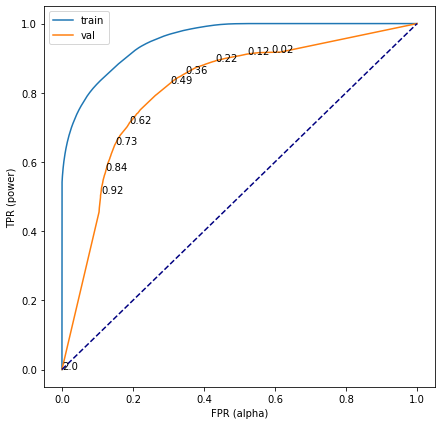

In [12]:
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

The ROC curve shows signs of overfitting<br>
We want to try some hyperparameter optimisation to reduce the discrepancy between train and validation

#### Grid Search CV with Decision Trees

In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

train: 0.9 test: 0.84
{'max_depth': 20, 'min_samples_leaf': 5}
Wall time: 6.27 s


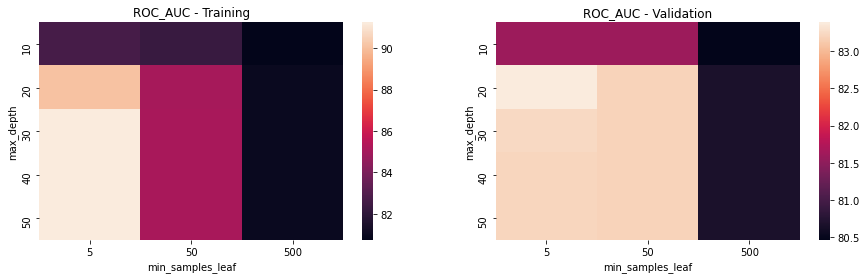

In [14]:
%%time
param_grid = {'max_depth':range(10,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.84


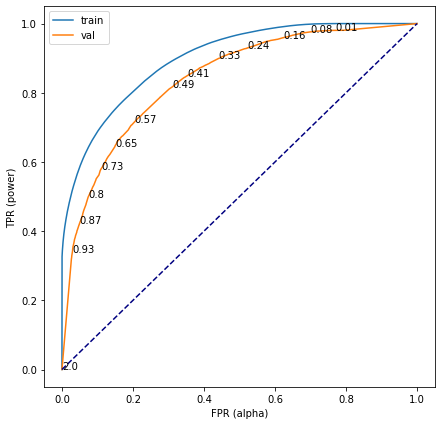

In [15]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.89 test: 0.84
{'max_depth': 20, 'min_samples_leaf': 10}
Wall time: 17 s


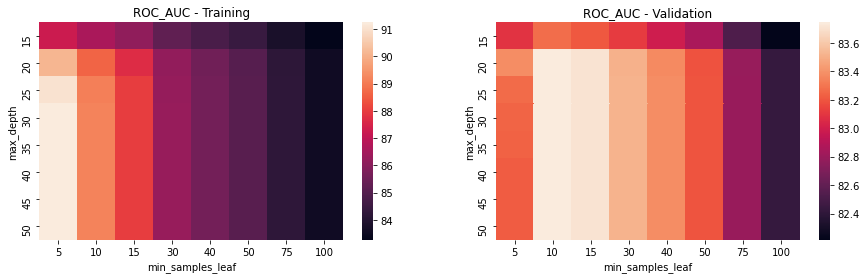

In [16]:
%%time
param_grid = {'max_depth':range(15,50+1,5),'min_samples_leaf':[5,10,15,30,40,50,75,100]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.89 test: 0.84


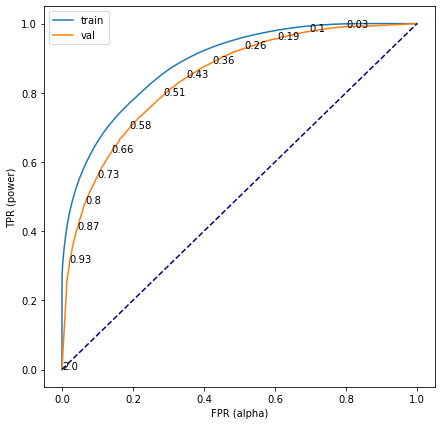

In [17]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.88 test: 0.84
{'max_depth': 25, 'min_samples_leaf': 16}
Wall time: 1min 35s


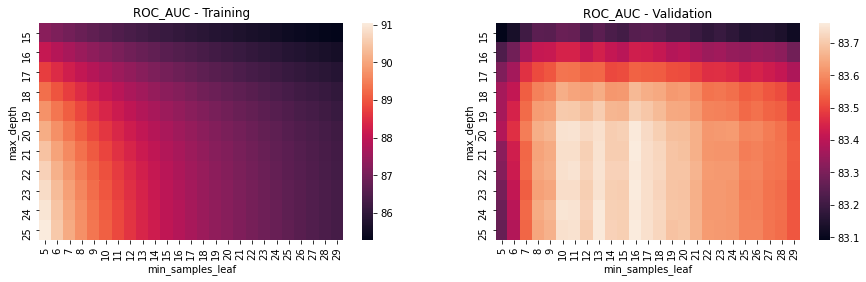

In [18]:
%%time
param_grid = {'max_depth':range(15,25+1),'min_samples_leaf':range(5,30)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.88 test: 0.84


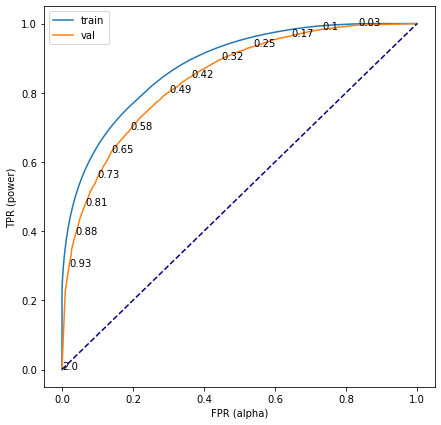

In [19]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [20]:
best_tree = best_model

Feature Importance

In [21]:
best_tree.feature_importances_

array([0.41967354, 0.58032646])

In [22]:
from sklearn import tree

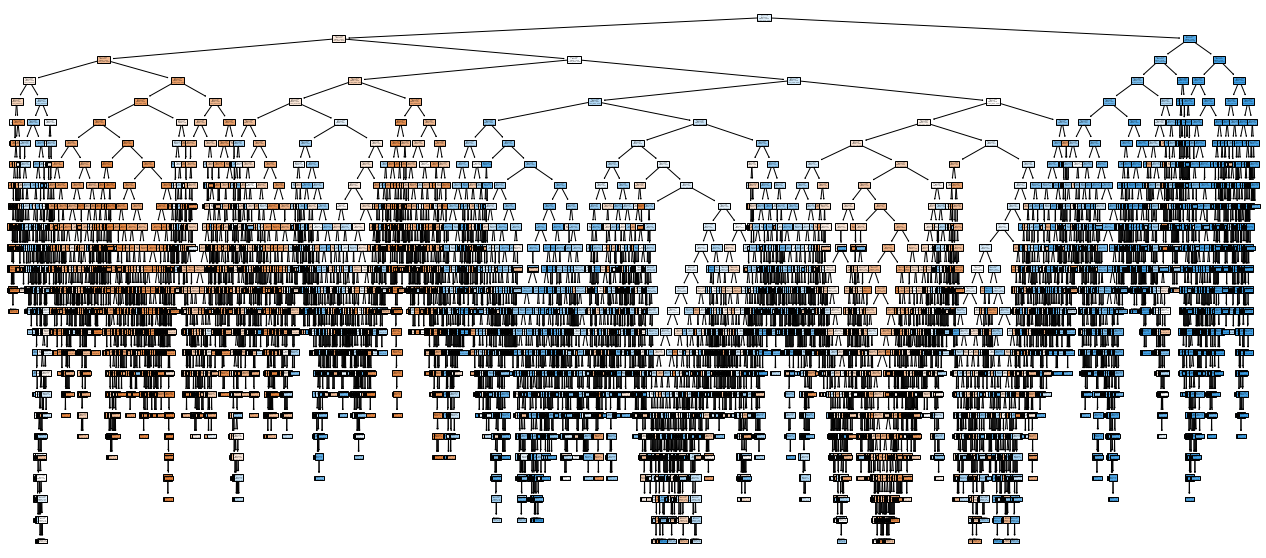

In [23]:
plt.figure(figsize=(22.3,10))
tree.plot_tree(best_tree, filled=True)
plt.show()

### Random Forest

#### Basic

In [24]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42)
model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

train: 0.94 test: 0.85


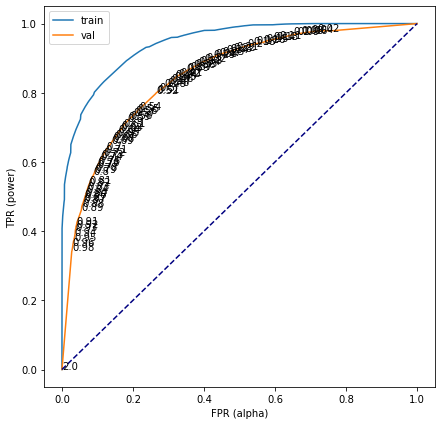

In [25]:
# Even off-the-shelf is better!!
scores(model,X_train,X_val,y_train,y_val)
roc_plot(model,X_train,y_train,X_val,y_val)

The ROC curve shows signs of overfitting<br>
We want to try some hyperparameter optimisation to reduce the discrepancy between train and validation

#### Grid Search CV with Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  68 out of  75 | elapsed:   16.7s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   17.4s finished


train: 0.9 test: 0.86
{'max_depth': 21, 'min_samples_leaf': 5}
Wall time: 18.3 s


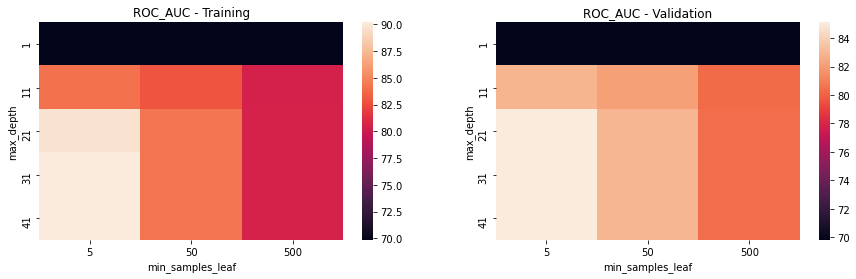

In [26]:
%%time
param_grid = {'max_depth':range(1,50+1,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1,verbose=10)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.86


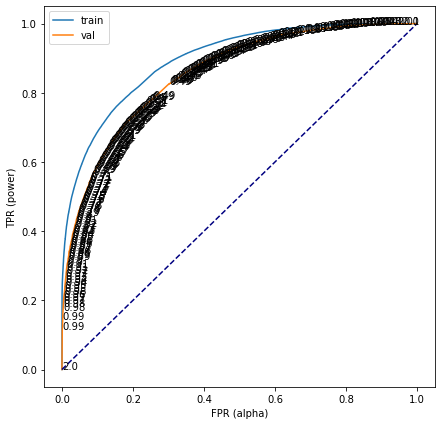

In [27]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.9 test: 0.85
{'max_depth': 25, 'min_samples_leaf': 5}
Wall time: 1min 27s


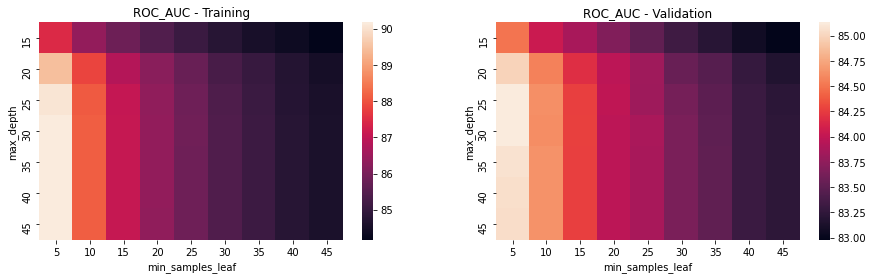

In [28]:
%%time
param_grid = {'max_depth':range(15,45+1,5),'min_samples_leaf':range(5,45+1,5)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.9 test: 0.85


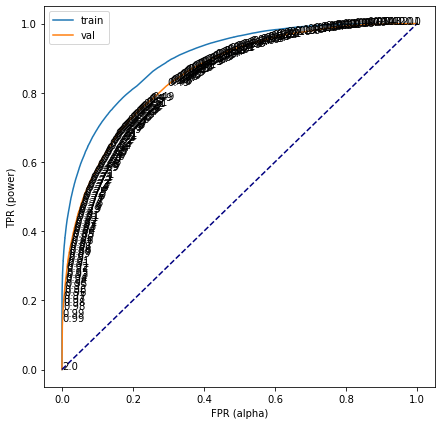

In [29]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.92 test: 0.86
{'max_depth': 22, 'min_samples_leaf': 2}
Wall time: 6min 33s


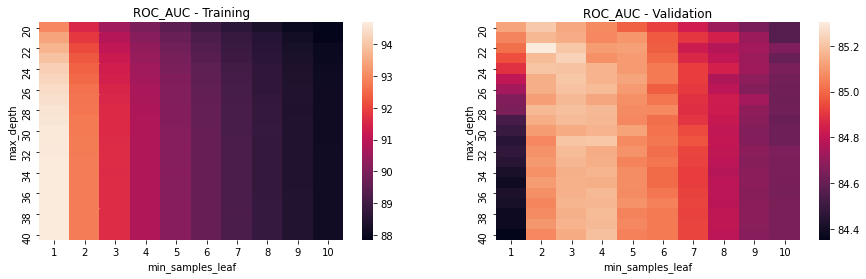

In [30]:
%%time
param_grid = {'max_depth':range(20,40+1,1),'min_samples_leaf':range(1,10+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)
plt.autoscale()

train: 0.92 test: 0.86


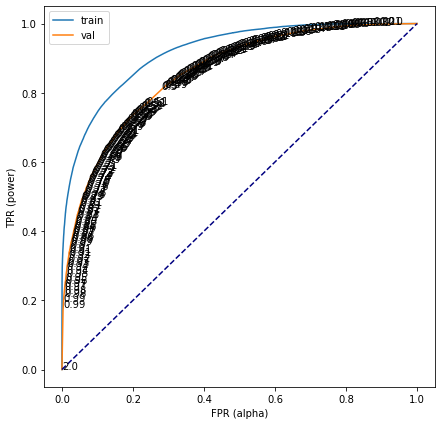

In [31]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

train: 0.92 test: 0.86
{'max_depth': 22, 'min_samples_leaf': 2}
Wall time: 2min 1s


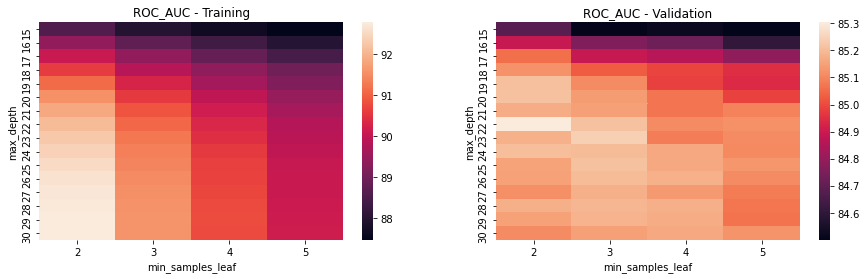

In [32]:
%%time
param_grid = {'max_depth':range(15,30+1),'min_samples_leaf':range(2,5+1)}

opt_model = GridSearchCV(model,param_grid,cv=skf,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
opt_plots(opt_model)

train: 0.92 test: 0.86


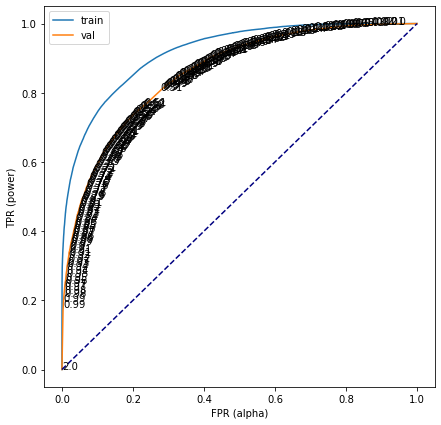

In [33]:
scores(best_model,X_train,X_val,y_train,y_val)
roc_plot(best_model,X_train,y_train,X_val,y_val)

In [34]:
best_forest = best_model

Feature Importance

In [35]:
best_forest.feature_importances_

array([0.4519798, 0.5480202])